In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

In [167]:
df_vnm = pd.read_csv('vnm.csv')
df_vnm = df_vnm[['Date', 'Price']]
df_vnm.columns = ['Date', 'vnm']
df_vnm

,Date,vnm
0,03/10/2023,"76,900.0"
1,03/09/2023,"76,500.0"
2,03/08/2023,"76,500.0"
3,03/07/2023,"75,800.0"
4,03/06/2023,"75,000.0"
...,...,...
2408,07/16/2013,"96,528.0"
2409,07/15/2013,"95,139.0"
2410,07/12/2013,"95,139.0"
2411,07/11/2013,"94,444.0"


In [168]:
df_vnindex = pd.read_csv('vnindex.csv')
df_vnindex = df_vnindex[['Date', 'Price']]
df_vnindex.columns = ['Date', 'vnindex']
df_vnindex

,Date,vnindex
0,03/25/2021,"1,163.10"
1,03/24/2021,"1,161.81"
2,03/23/2021,"1,183.45"
3,03/22/2021,"1,194.43"
4,03/19/2021,"1,194.05"
...,...,...
4994,08/09/2000,108.64
4995,08/07/2000,106.92
4996,08/04/2000,105.20
4997,08/02/2000,103.38


In [169]:
stocks_df = pd.concat([df_vnindex, df_vnm.drop(columns=["Date"])], axis = 1)
stocks_df.dropna(inplace=True)
stocks_df


,Date,vnindex,vnm
0,03/25/2021,"1,163.10","76,900.0"
1,03/24/2021,"1,161.81","76,500.0"
2,03/23/2021,"1,183.45","76,500.0"
3,03/22/2021,"1,194.43","75,800.0"
4,03/19/2021,"1,194.05","75,000.0"
...,...,...,...
2408,08/02/2011,396.55,"96,528.0"
2409,08/01/2011,401.95,"95,139.0"
2410,07/29/2011,405.70,"95,139.0"
2411,07/28/2011,408.39,"94,444.0"


In [170]:
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'].str.replace(',',''))
stocks_df['vnindex'] = pd.to_numeric(stocks_df['vnindex'].str.replace(',',''))
stocks_df['vnm'] = pd.to_numeric(stocks_df['vnm'].str.replace(',',''))
stocks_df.sort_values('Date', inplace=True, ignore_index=True)
stocks_df

,Date,vnindex,vnm
0,2011-07-27,409.40,94444.0
1,2011-07-28,408.39,94444.0
2,2011-07-29,405.70,95139.0
3,2011-08-01,401.95,95139.0
4,2011-08-02,396.55,96528.0
...,...,...,...
2408,2021-03-19,1194.05,75000.0
2409,2021-03-22,1194.43,75800.0
2410,2021-03-23,1183.45,76500.0
2411,2021-03-24,1161.81,76500.0


In [171]:
# Let's make a function to do that
def normalize_stocks(df):
    df_ = df.copy() # it is a good idea in general to make a copy
    for stock in df_.columns[1:]:
        df_[stock] = df_[stock] / df_.loc[0, stock]
    return df_

norm_stocks_df = normalize_stocks(stocks_df)
norm_stocks_df.head(5)

,Date,vnindex,vnm
0,2011-07-27,1.000000,1.000000
1,2011-07-28,0.997533,1.000000
2,2011-07-29,0.990962,1.007359
3,2011-08-01,0.981803,1.007359
4,2011-08-02,0.968613,1.022066


In [172]:
fig = px.line(title = "Normalized stock prices")
 
# Loop through each stock (while ignoring time columns with index 0)
for stock in norm_stocks_df.columns[1:]:
    fig.add_scatter(x = norm_stocks_df["Date"], y = norm_stocks_df[stock], name = stock)
fig.show()

In [173]:
def daily_return_estimator(df):
    df_daily_return = df.copy()

# Loop through each stock (column of the dataframe except Date collumn)
    for i in df.columns[1:]:
 
        # Loop through each row/price belonging to the stock
        for j in range(1, len(df)):

            # Calculate the percentage of change from the previous day's close price. 
            # Simple equation of percentage change.
            df_daily_return[i][j] = ((df[i][j]- df[i][j-1])/df[i][j-1]) * 100
 
         # set the value of first row to zero (previous value is not available)
        df_daily_return.loc[0, i] = 0
 
    return df_daily_return

In [174]:
stocks_daily_return = daily_return_estimator(stocks_df)
stocks_daily_return.head(5)

,Date,vnindex,vnm
0,2011-07-27,0.000000,0.000000
1,2011-07-28,-0.246702,0.000000
2,2011-07-29,-0.658684,0.735886
3,2011-08-01,-0.924328,0.000000
4,2011-08-02,-1.343451,1.459969


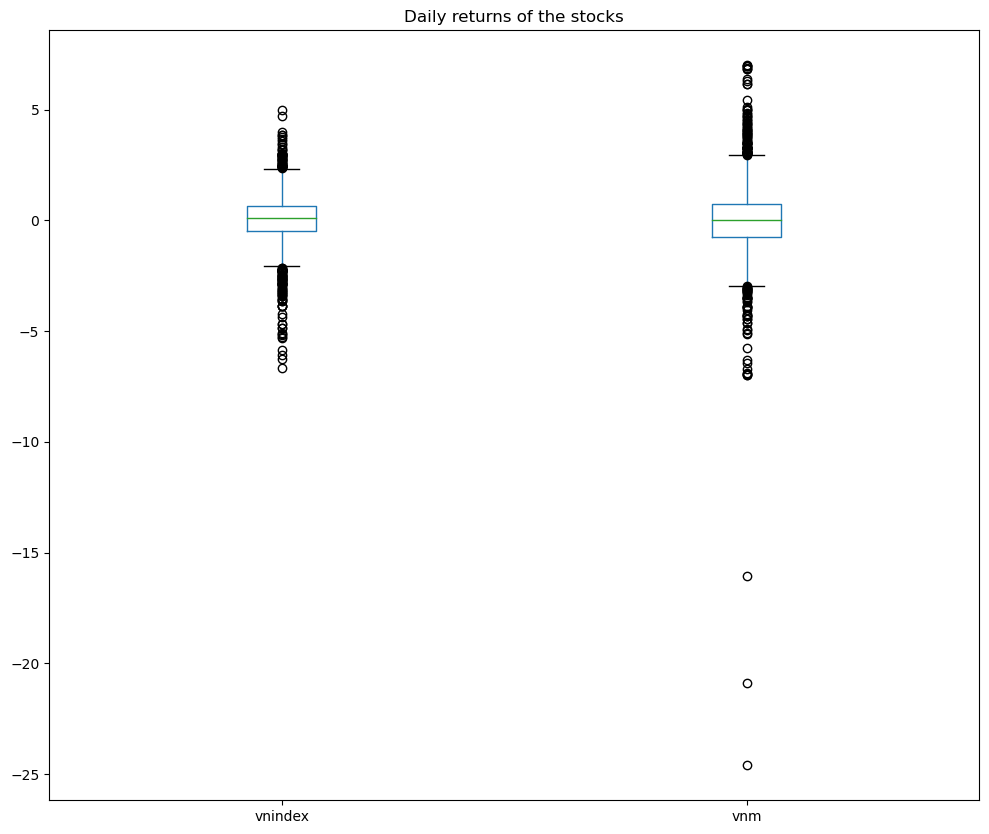

In [175]:
# Histogram of daily returns (in %)

stocks_daily_return.boxplot(figsize=(12, 10), grid=False)
plt.title("Daily returns of the stocks")
plt.show()

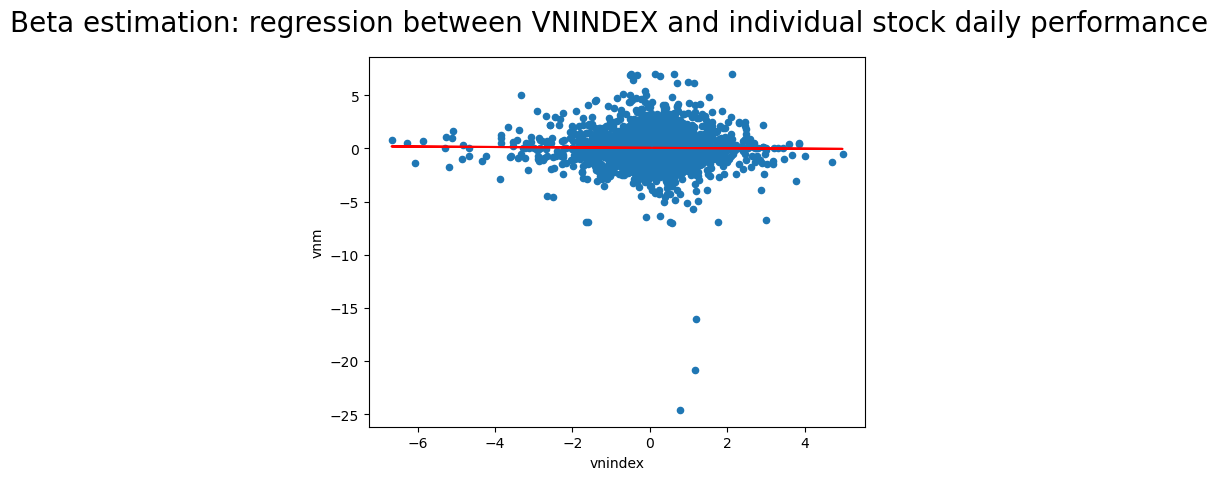

In [176]:
# Initialize empty dictionaries to save results
beta,alpha = dict(), dict()
stocks_daily_return.plot(kind = "scatter", x = "vnindex", y = 'vnm')

# Fit a line (regression using polyfit of degree 1)
b_, a_ = np.polyfit(stocks_daily_return['vnm'], stocks_daily_return["vnindex"], 1)

regression_line = b_ * stocks_daily_return["vnindex"] + a_
plt.plot(stocks_daily_return["vnindex"], regression_line, "-", color = "r")

# save the regression coeeficient for the current stock
beta[stock] = b_
alpha[stock] = a_

plt.suptitle("Beta estimation: regression between VNINDEX and individual stock daily performance", size=20)
plt.show()

In [177]:
# Initialize the expected return dictionary
ER = dict()
rf = 0 # assume risk-free rate is zero in this case

# Estimate the expected return of the market using the daily returns
rm = stocks_daily_return["vnindex"].mean() * 253

In [178]:
keys = list(beta.keys())
for k in keys:
    # Calculate return for every security using CAPM 
    ER[k] = rf + beta[k] * (rm-rf)

for k in keys:
    print("Expected return based on CAPM model for {} is {}%".format(k, ER[k]))

Expected return based on CAPM model for vnm is -0.25008626362883324%


In [179]:
for k in keys:
    print('Return based on historical data for {} is {}%'.format(k, stocks_daily_return[k].mean() * 252))

Return based on historical data for vnm is 1.4650466054112148%
